# VSR performance analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Mixed seeds performance

We evaluate each evolved VSR using a distributed controller architecture.
In each voxel we place the controller evolved for the given morphology.
Most voxels, i.e., $(1-r)n$, $r$ being the rate and $n$ being the total number of voxels, are equipped with the controller evolved with a set random seed.
The remainder of voxels are equipped with controllers evolved with different random seeds.

In [19]:
cross_seed_df = pd.read_csv("mixed_seeds_validation.csv")
cross_seed_df["relative_performance_loss"] = (cross_seed_df.baseline_vx - cross_seed_df.vx) / cross_seed_df.baseline_vx
for target_set in cross_seed_df.target_set.unique():
  for shape_id in cross_seed_df.shape_id.unique():
    for seed in cross_seed_df.main_seed.unique():
      temp = cross_seed_df[
        (cross_seed_df.target_set == target_set) & (cross_seed_df.shape_id == shape_id)
        & (cross_seed_df.main_seed == seed)].copy().head(1)
      if len(temp) > 0:
        temp.vx = temp.baseline_vx
        temp.rate = 0
        cross_seed_df = pd.concat([cross_seed_df, temp], ignore_index=True)
cross_seed_df = cross_seed_df[cross_seed_df.target_set != 4]
cross_seed_df.head()

,target_set,shape_id,main_seed,readable_shape,baseline_vx,rate,rep,vx,seed_shape,relative_performance_loss
0,1,0,1,1111-1111-1001,3.266257,0.2,2.0,-0.028750,1111-4151-1xx1,1.008802
1,1,0,1,1111-1111-1001,3.266257,0.2,6.0,-0.020600,3111-1111-2xx1,1.006307
2,1,0,1,1111-1111-1001,3.266257,0.4,6.0,0.635768,5111-2312-1xx1,0.805353
3,1,0,1,1111-1111-1001,3.266257,0.3,6.0,0.004619,5111-4141-1xx1,0.998586
4,1,0,1,1111-1111-1001,3.266257,0.2,1.0,0.175104,1111-1114-3xx1,0.946390


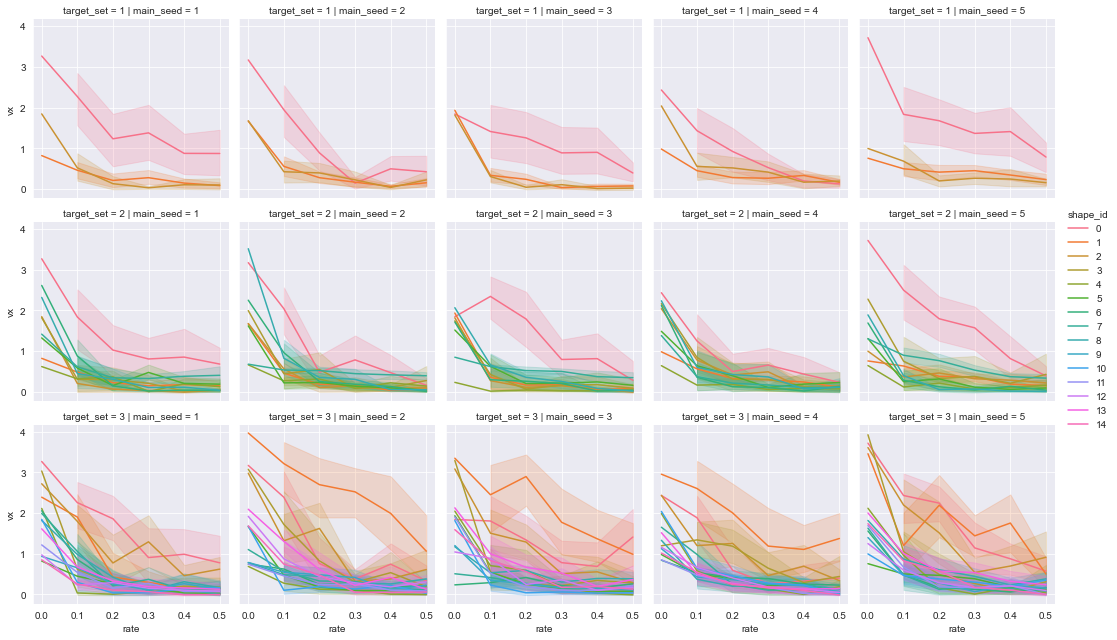

In [20]:
g = sns.FacetGrid(cross_seed_df, row="target_set", col="main_seed", hue="shape_id")
g.map_dataframe(sns.lineplot, x="rate", y="vx")
g.add_legend()
plt.show()